In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2 as cv
import numpy as np
import math
from google.colab.patches import cv2_imshow as cv_imshow
from skimage import measure
from matplotlib import pyplot as plt

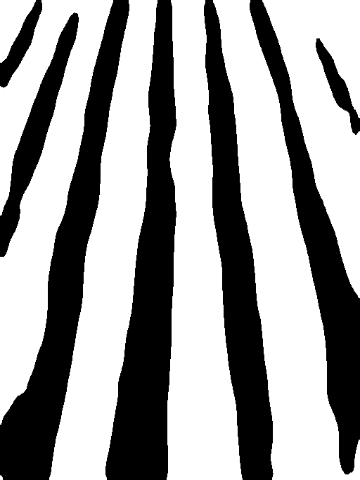

In [ ]:
#filename_image = "/content/gdrive/MyDrive/TCC/Dataset/images/592.png"
#filename_mask = "/content/gdrive/MyDrive/TCC/Dataset/predict/592.png"

#filename_image = "/content/gdrive/MyDrive/TCC/Dataset/images/592.png"
filename_mask = "/content/gdrive/MyDrive/TCC/Dataset/predict_soybean/275.png"

#load_image = cv.imread(filename_image)
#image_original = cv.resize(load_image, (360, 480))
load_mask = cv.imread(filename_mask, cv.IMREAD_GRAYSCALE)
src = cv.resize(load_mask, (360, 480))

cv_imshow(src)

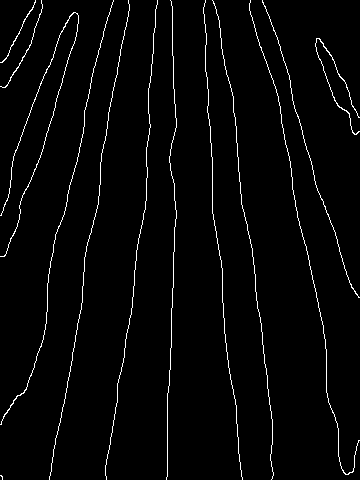

In [ ]:
dst = cv.Canny(src, 100, 200, None, 3)
cv_imshow(dst)

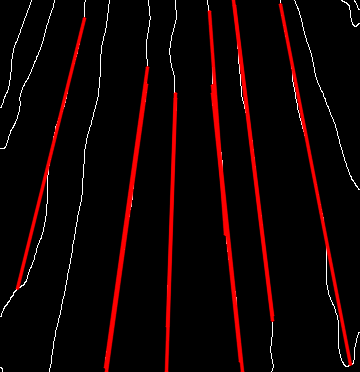

In [ ]:
# Porcentagem da altura a ser ignorada
per_altura = 0.70
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
dst2 = np.copy(dst)[int((1-per_altura)*dst.shape[1]):,:]
altura_maior, largura = dst.shape[:2]

linesP = cv.HoughLinesP(dst2, 1, np.pi / 180, 50, None, 200, 120)#[:3]

cdst2 = cv.cvtColor(dst2, cv.COLOR_GRAY2BGR)
cdstP2 = np.copy(cdst2)

pontos = []
coefs = []
altura_menor, largura = cdstP2.shape[:2]

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        if (l[0] + l[2] < 10 or l[1] + l[3] < 10 or l[1] + l[3] > 2*cdstP2.shape[1] - 10):
          continue

        x1, y1 = l[0], l[1]
        x2, y2 = l[2], l[3]

        z1 = altura_menor - y1
        z2 = altura_menor - y2

        # 1. Calcular as reta na forma x = a*z + b
        a = (x1 - x2) / (z1 - z2)
        b = x1 - a * z1

        coefs.append([b, a])

        #print(l)
        cv.line(cdstP2, (l[0], l[1]), (l[2], l[3]), (0,0,255), 2, cv.LINE_AA)
        pontos.append(linesP[i][0])

coefs.sort()
coefs.append([-1, -1])

cv_imshow(cdstP2)

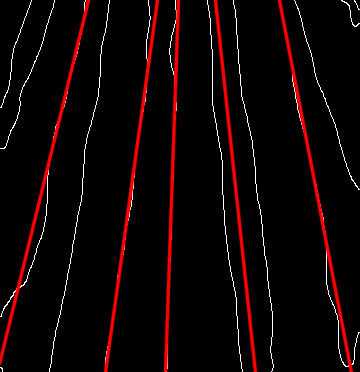

In [ ]:
# 2. Ordenar e filtrar retas semelhantes

similaridade = 0.25
new_coefs = []
b_anterior, a_anterior = coefs[0]
b_similar = [b_anterior]
a_similar = [a_anterior]
for b, a in coefs[1:]:
  has_similarity = abs(1 - a/a_anterior) < 2*similaridade and abs(1 - b/b_anterior) < similaridade
  #print (b, a, has_similarity, abs(1 - a/a_anterior), abs(1 - b/b_anterior))
  if (has_similarity):
    a_similar.append(a)
    b_similar.append(b)
  else:
    new_coefs.append([np.mean(b_similar), np.mean(a_similar)])
    a_similar = [a]
    b_similar = [b]

  a_anterior = a
  b_anterior = b

# Exibindo retas
def show_lines (coefs, matrix):
  cdstP = np.copy(matrix)

  #altura2 = altura_menor + int((1-per_altura)*dst.shape[1])
  for b, a in coefs:
      y1 = int(altura_maior*3/4)
      y2 = altura_maior
      z1 = altura_maior - y1
      z2 = altura_maior - y2
      x1 = int(a * z1 + b)
      x2 = int(a * z2 + b)

      cv.line(cdstP, (x1, y1), (x2, y2), (0,0,255), 2, cv.LINE_AA)

  cv_imshow(cdstP)

def show_lines2 (coefs, matrix):
  cdstP = np.copy(matrix)

  for b, a in coefs:
      y1 = 0
      y2 = altura_menor
      z1 = altura_menor - y1
      z2 = altura_menor - y2
      x1 = int(a * z1 + b)
      x2 = int(a * z2 + b)

      cv.line(cdstP, (x1, y1), (x2, y2), (0,0,255), 2, cv.LINE_AA)

  cv_imshow(cdstP)

# Exibindo retas
show_lines2(new_coefs, cdst2)


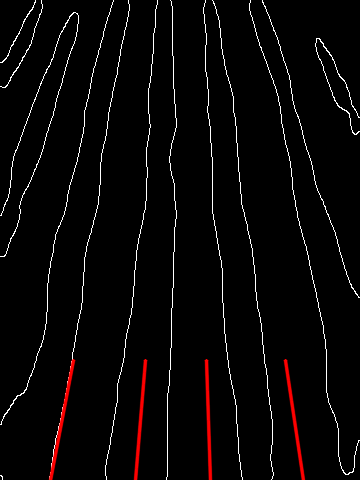

In [ ]:
# 3. Calcular as retas centrais
new_coefs2 = np.array(new_coefs)
new_coefs3 = 0.5*(new_coefs2[1:] + new_coefs2[:-1])

# Exibindo retas
show_lines(new_coefs3, cdst)

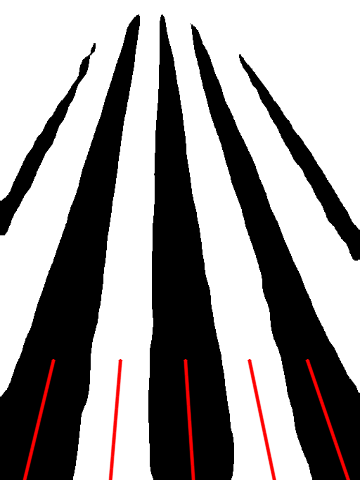

In [ ]:
# 4. Eliminar retas fora da área de interesse
perc_altura = 0.7

new_coefs4 = []
z_ini = perc_altura * altura_maior
for b, a in new_coefs3:
  x_ini = a * z_ini + b
  if (0 <= x_ini <= largura):
    new_coefs4.append([b,a])

# Exibindo retas
src2 = cv.cvtColor(src, cv.COLOR_GRAY2BGR)
show_lines(new_coefs4, src2)


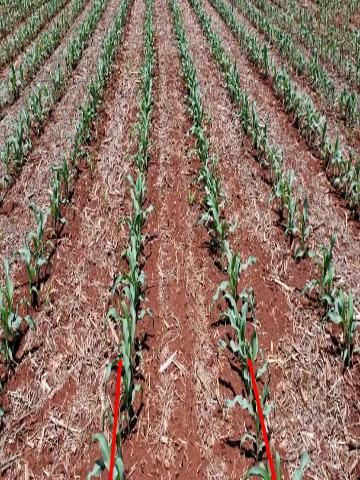

In [ ]:
# 5. Determinar as cores predominantes nas retas
final_coefs = []
for b, a in new_coefs4:
  accum = []
  for z in range(int(z_ini), -1, -1):
    x = int(a * z + b)
    if (0 <= x < largura):
      accum.append(src[-z, x])

  if (np.mean(accum) > 220):
    final_coefs.append ((b, a))

show_lines(final_coefs, image_original)